## using treesignal on euk_ToL using sptrees from iGTP and genetrees from RAxML
- iGTP was run on samples of 150 gene trees, using DupLoss cost (100 runs in total)
- the list of gene trees for iGTP was the first (MAP?) tree estimated by phylobayes (Miguel data). Notice that first tree doesn't mean much since many flat surfaces...
- while iGTP will give us the set of reference (species) trees, the samples we will plot are the RAxML gene trees.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import sys, subprocess, time, dendropy, os, copy, glob
import numpy as np
from sklearn import manifold, metrics, cluster, neighbors, decomposition, preprocessing
import treesignal

### Loading reference trees (sptrees)
100 estimates using iGTP duploss cost. We also add "noise" (SPR neighbours) since this function also removes duplicated trees. Some iGTP sptrees miss one species, and therefore must be excluded.

In [2]:
#f_dir = "/home/leo/Academic/Projects/164-Katz/12.concat_mbayes_output_201705/201704.igtp_output/result_0407/igtp*"
f_dir = "/home/leomrtns/guenomu_local/2017.miguel_tol/result_0407/igtp*"
spstring = ""
for file in glob.glob(f_dir):
    sptree = dendropy.TreeList.get_from_path (file, "newick", preserve_underscores=True)
    if(len(sptree[0].leaf_nodes()) == 155):
        spstring += sptree[0].as_string("newick",suppress_edge_lengths=True).rstrip().replace("'","")
    
sptrees = treesignal.lowlevel_randomise_trees_with_spr_string(spstring, n_copies=2, n_spr=3)

### Read gene trees and calculate feature matrix rows 
* Reading only first tree from each file
* function yield_from_files allow several files to be read at once, and trees being read one by one
* the calculated distances are scaled (using a single scaling factor for all distances, which is total number of branches (on both trees)

In [3]:
ts = treesignal.TreeSignal(sp_trees = dendropy.TreeList.get( data=sptrees, schema="newick"), replicates=500)

#f_dir = "/home/leo/Academic/Projects/164-Katz/12.concat_mbayes_output_201703/201705.raxml/OG5_*"
f_dir = "/home/leomrtns/guenomu_local/2017.miguel_tol/201705.raxml/OG5_*"
feat_mat = []
genesize = []

for file in glob.glob(f_dir):
    tyield = dendropy.Tree.yield_from_files(files=[file], schema="nexus", preserve_underscores=True)
    for idx, tre in enumerate (tyield): # iterate over trees as it reads (not everything in memory at once)
        if idx > 0: # read only first trees
            break
        else:
            #print (tre.as_string("newick",suppress_edge_lengths=True).replace("'",""))
            spectrum = ts(tre)
            if spectrum.max() > -1.: # if genetree is too small etc. there is no spectrum
                feat_mat.append(spectrum)
                genesize.append(len(tre.leaf_nodes()))
    
feat_mat = np.array(feat_mat)
genesize = np.array(genesize)
print ("dimensions: ", feat_mat.shape) 

dimensions:  (2967, 3456)


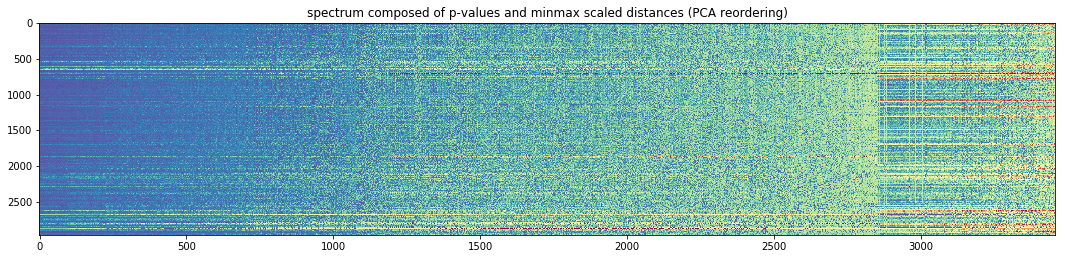

In [4]:
## order of the FEATURES (distances) using first PC 
feat_order = np.argsort(decomposition.PCA(n_components=2).fit_transform(feat_mat.T)[:,0])
fig, axes = plt.subplots(1) ; fig.set_size_inches(15,3)
fig.subplots_adjust(top=.99, bottom=.01, left=.03, right=.97, wspace=.1, hspace=.1)
axes.imshow(feat_mat[:,feat_order],aspect='auto', cmap="Spectral_r", interpolation="nearest")
axes.set_title("spectrum composed of p-values and minmax scaled distances (PCA reordering)")

In [5]:
#fmatrix = feat_mat[:,int(feat_mat.shape[1]/2):]
fmatrix = feat_mat/feat_mat.mean(0)
transf_T = manifold.TSNE(n_components=2, perplexity=20, n_iter=5000).fit_transform(fmatrix)
transf_I = manifold.Isomap(n_neighbors=10, n_components=2).fit_transform(fmatrix)
transf_M = manifold.MDS(n_components=2).fit_transform(fmatrix)
transf_S = manifold.SpectralEmbedding(n_components=2).fit_transform(fmatrix)

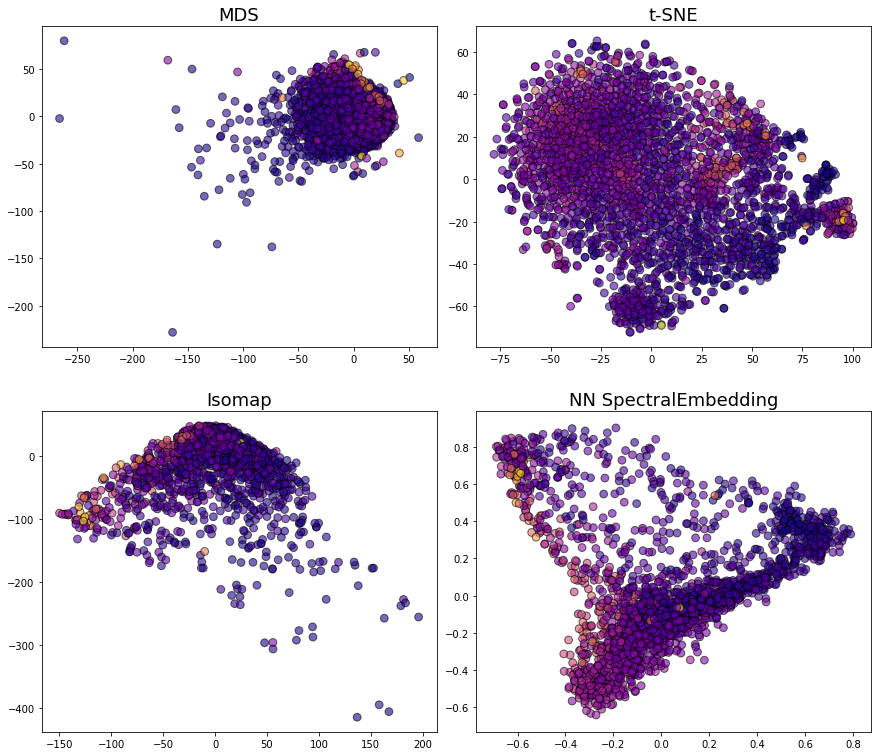

In [6]:
#  %%script false # tell jupyter NOT TO RUN cell (on linux only)
fig, axes = plt.subplots(2,2) ; fig.set_size_inches(12, 10)
fig.subplots_adjust(top=.99, bottom=.01, left=.02, right=.98, wspace=.1, hspace=.2)
 
axes[0,0].scatter(transf_M[:,1], transf_M[:,0], c=genesize, edgecolor="black", cmap="plasma", alpha=.6, s=60)
axes[0,0].set_title("MDS",  fontsize=18)
axes[0,1].scatter(transf_T[:,1], transf_T[:,0], c=genesize, edgecolor="black", cmap="plasma", alpha=.6, s=60)
axes[0,1].set_title("t-SNE",  fontsize=18)
axes[1,0].scatter(transf_I[:,1], transf_I[:,0], c=genesize, edgecolor="black", cmap="plasma", alpha=.6, s=60)
axes[1,0].set_title("Isomap",  fontsize=18)
axes[1,1].scatter(transf_S[:,1], transf_S[:,0], c=genesize, edgecolor="black", cmap="plasma", alpha=.6, s=60)
axes[1,1].set_title("NN SpectralEmbedding",  fontsize=18)